# **Predicting Language Using Readme Files**
**By Data Scientist: Gabe Cavazos, Adriana Nuncio, & DeAdrien Hill**

# Acquire


In [1]:
# Imports
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import prepare_github as prepare
from wordcloud import WordCloud
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import models_adriana
#ignore all warnings, it's all good, trust me
import warnings
warnings.simplefilter(action='ignore')

In [2]:
#get the newest data from github using the acquire.py file
#this may or maynot reproduce the results of our findings
#it might invalidate our exploration and change the results of the model performance
#ensure you have changed the values in the env.py


#import acquire
#df=acquire.scrape_github_data()

In [3]:
# Run to reproduce our results
df = pd.read_csv('github_data.csv')

In [4]:
# Show first few rows
df.head()

,repo,language,readme_contents
0,nightscout/cgm-remote-monitor,JavaScript,Nightscout Web Monitor (a.k.a. cgm-remote-moni...
1,angular/angular.js,JavaScript,AngularJS [![CircleCI](https://circleci.com/gh...
2,trekhleb/javascript-algorithms,JavaScript,# JavaScript Algorithms and Data Structures\n\...
3,jquery/jquery,JavaScript,[jQuery](https://jquery.com/) — New Wave JavaS...
4,TheOdinProject/javascript-exercises,JavaScript,# JavaScript Exercises\n\nThese JavaScript exe...


# Prepare

In [5]:
# Call prepare function 
df = prepare.transform_data(df)

In [6]:
# Verify updated values
df.head()

,repo,language,original,clean,stemmed,lematized
0,nightscout/cgm-remote-monitor,JavaScript,Nightscout Web Monitor (a.k.a. cgm-remote-moni...,nightscout web monitor aka cgmremotemonitor ni...,nightscout web monitor aka cgmremotemonitor ni...,nightscout web monitor aka cgmremotemonitor ni...
1,angular/angular.js,JavaScript,AngularJS [![CircleCI](https://circleci.com/gh...,angularjs circlecihttpscirclecicomghangularang...,angularj circlecihttpscirclecicomghangularangu...,angularjs circlecihttpscirclecicomghangularang...
2,trekhleb/javascript-algorithms,JavaScript,# JavaScript Algorithms and Data Structures\n\...,javascript algorithms data structures ukraine ...,javascript algorithm data structur ukrain atta...,javascript algorithms data structure ukraine a...
3,jquery/jquery,JavaScript,[jQuery](https://jquery.com/) — New Wave JavaS...,jqueryhttpsjquerycom new wave javascript gitte...,jqueryhttpsjquerycom new wave javascript gitte...,jqueryhttpsjquerycom new wave javascript gitte...
4,TheOdinProject/javascript-exercises,JavaScript,# JavaScript Exercises\n\nThese JavaScript exe...,javascript exercises javascript exercises inte...,javascript exercis javascript exercis intend c...,javascript exercise javascript exercise intend...


In [7]:
# Check the shape of the DataFrame
df.shape

(119, 6)

In [8]:
# Get summary statistics of the DataFrame
df.describe()

,repo,language,original,clean,stemmed,lematized
count,119,119,119,119,119,119
unique,109,4,109,109,109,109
top,scutan90/DeepLearning-500-questions,JavaScript,\n# 京东售卖链接：https://item.jd.com/12785031.html\n...,httpsitemjdcom12785031html 100 500ai 141347cnn...,httpsitemjdcom12785031html 100 500ai 141347cnn...,httpsitemjdcom12785031html 100 500ai 141347cnn...
freq,2,30,2,2,2,2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 119
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   repo       119 non-null    object
 1   language   119 non-null    object
 2   original   119 non-null    object
 3   clean      119 non-null    object
 4   stemmed    119 non-null    object
 5   lematized  119 non-null    object
dtypes: object(6)
memory usage: 6.5+ KB


# Exploration 

We are looking to gain insights into the programming language distribution in GitHub repositories and to identify any patterns or trends related to programming languages based on readme text. This information can be useful for developers and organizations to prioritize their language learning or investment decisions.

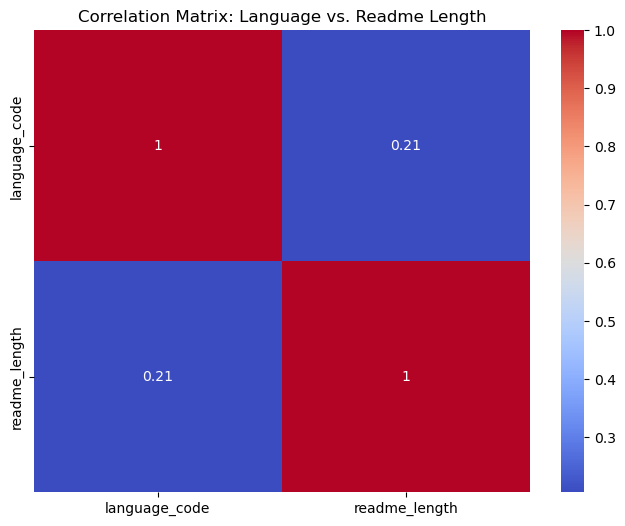

In [10]:
# Convert language labels to numerical values
df['language_code'] = df['language'].astype('category').cat.codes

# Calculate the length of each readme content
df['readme_length'] = df['original'].apply(len)

# Compute correlation matrix
corr_matrix = df[['language_code', 'readme_length']].corr()

# Heatmap of correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: Language vs. Readme Length')
plt.show()


JavaScript    30
Java          30
C             30
Python        29
Name: language, dtype: int64


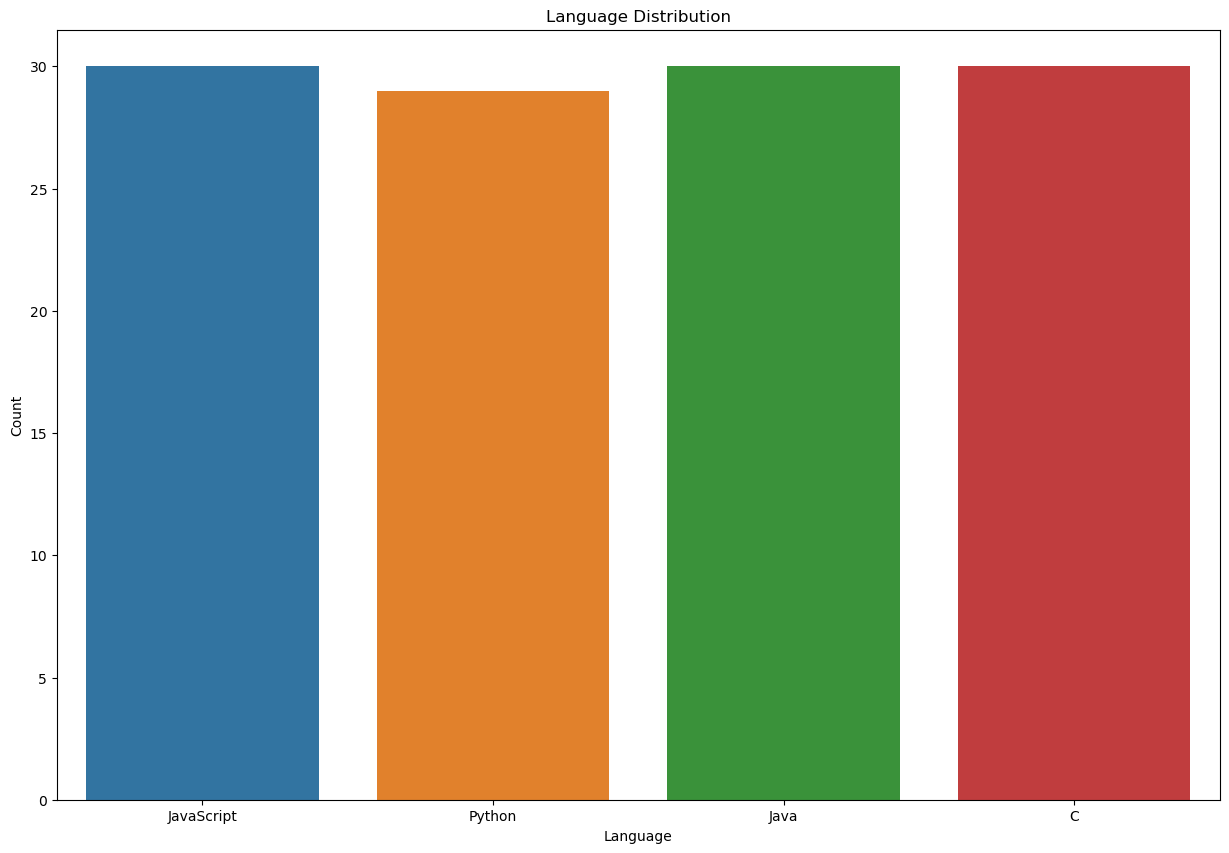

In [11]:
# Count the number of each language
language_counts = df['language'].value_counts()
print(language_counts)

# Language distribution
plt.figure(figsize=(15, 10))
sns.countplot(x='language', data=df)
plt.title('Language Distribution')
plt.xlabel('Language')
plt.ylabel('Count')
plt.show()

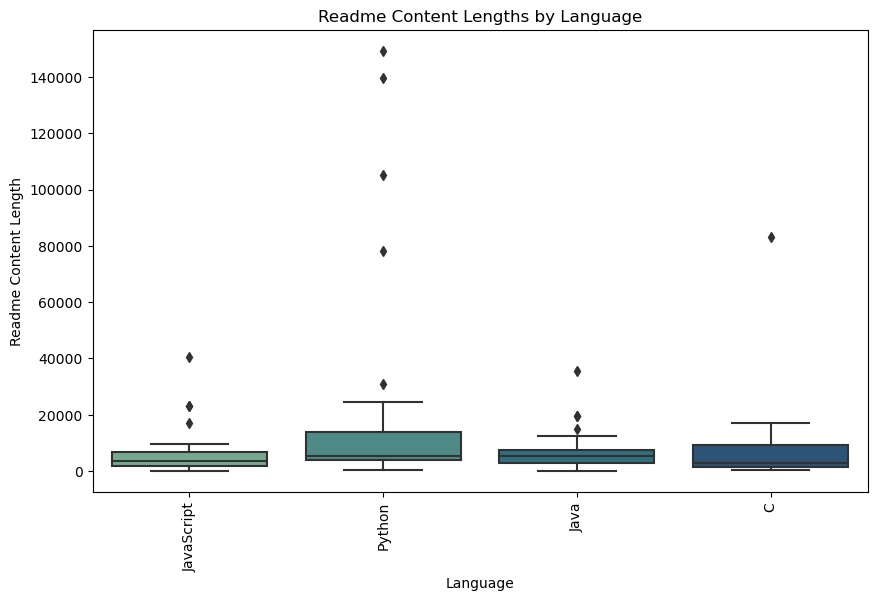

In [12]:
# Add a column for readme content lengths
df['readme_length'] = df['clean'].apply(len)

# Box plot of readme content lengths by language
plt.figure(figsize=(10, 6))
sns.boxplot(x='language', y='readme_length', data=df, palette='crest')
plt.title('Readme Content Lengths by Language')
plt.xlabel('Language')
plt.ylabel('Readme Content Length')
plt.xticks(rotation=90)
plt.show()

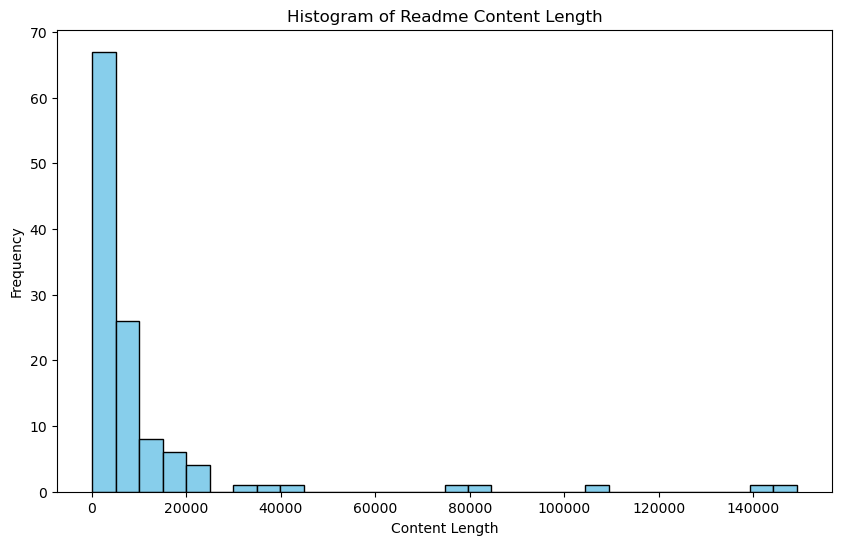

In [13]:
# Calculate the length of each readme content
df['content_length'] = df['clean'].apply(len)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['content_length'], bins=30, color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Histogram of Readme Content Length')
plt.xlabel('Content Length')
plt.ylabel('Frequency')

# Display the plot
plt.show()


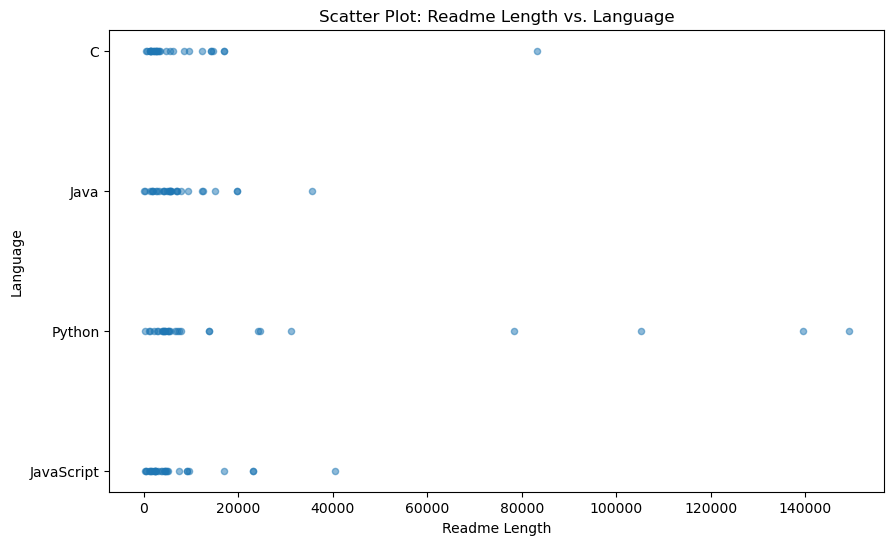

In [14]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['readme_length'], df['language'], s=20, alpha=0.5)

# Customize the plot
plt.title('Scatter Plot: Readme Length vs. Language')
plt.xlabel('Readme Length')
plt.ylabel('Language')

# Display the plot
plt.show()



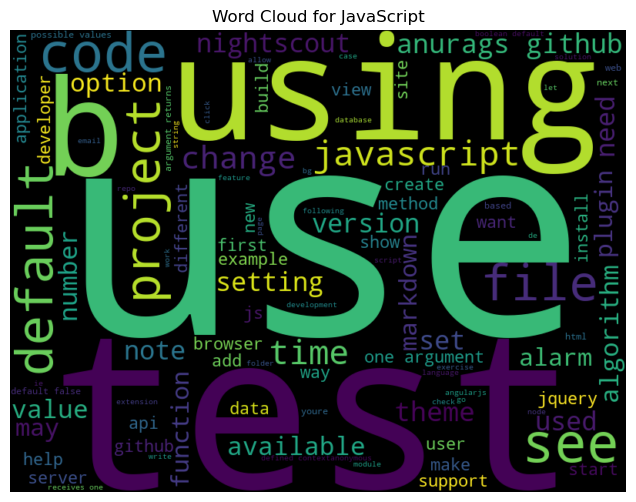

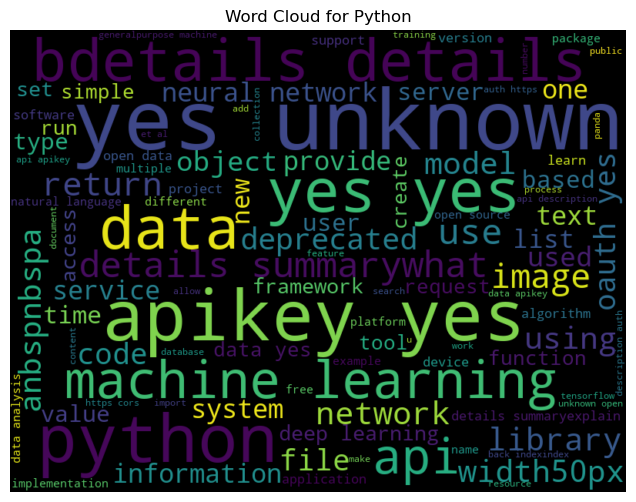

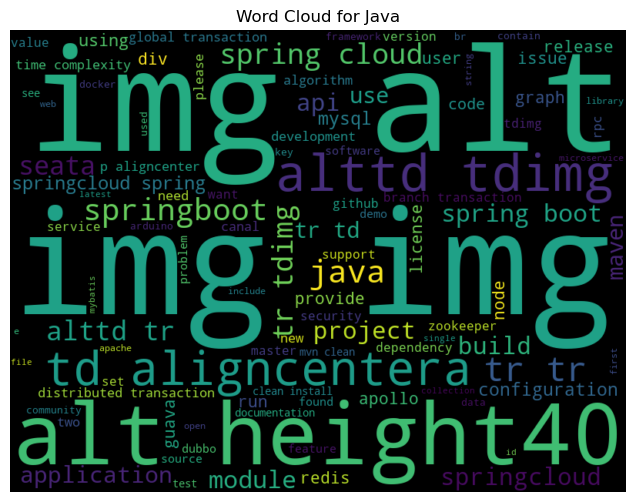

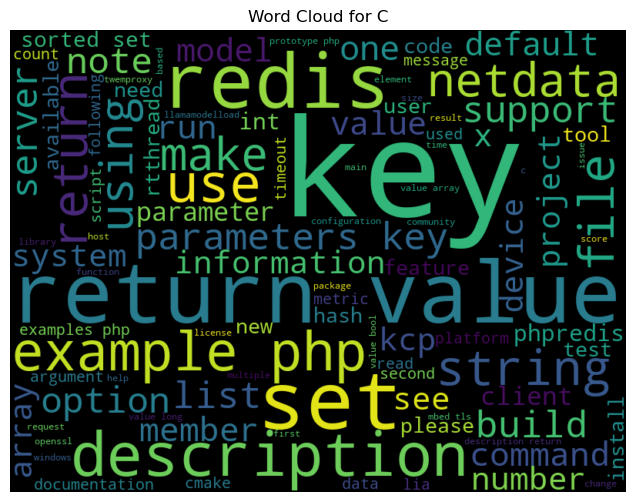

In [15]:
# Create a word cloud for each language
languages = df['language'].unique()
for language in languages:
    plt.figure(figsize=(8, 6))
    subset = df[df['language'] == language]
    text = ' '.join(subset['clean'])
    wordcloud = WordCloud(width=800, height=600, max_words=100).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {language}')
    plt.axis('off')
    plt.show()

# Stats Test

# 1. Is there a readme for each repository in the trending programming languages?


In [16]:
# Create a contingency table of language frequencies
contingency_table = pd.crosstab(df['language'], columns='count')

# Perform the chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Set the significance level (alpha)
alpha = 0.05

# Check if the null hypothesis should be rejected
if p_value < alpha:
    print("Null hypothesis (H0): The frequencies of all programming language readmes in the dataset are equal.")
else:
    print("Alternative hypothesis (Ha): The frequencies of programming language readmes in the dataset are not equal.")

Alternative hypothesis (Ha): The frequencies of programming language readmes in the dataset are not equal.


# 2. Where is the inequality comming from?

In [17]:
contingency_table

col_0,count
language,
C,30
Java,30
JavaScript,30
Python,29


python had a repo without a readme

# 3.  Does readme length play a factor in the programming language?

In [18]:
# Perform one-way ANOVA
result = f_oneway(df['readme_length'][df['language'] == 'Python'],
                  df['readme_length'][df['language'] == 'JavaScript'],
                  df['readme_length'][df['language'] == 'Java'],
                  df['readme_length'][df['language'] == 'Ruby'])

# Set the significance level (alpha)
alpha = 0.05

# Check if the null hypothesis should be rejected
if result.pvalue < alpha:
    print("Null Hypothesis (H0): There is no significant difference in the mean readme length across different programming languages.")
else:
    print("Alternative Hypothesis (HA): There is a significant difference in the mean readme length across different programming languages.")

Alternative Hypothesis (HA): There is a significant difference in the mean readme length across different programming languages.


# 4. Are there any common words or phrases that are indicative of specific languages?

In [19]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the readme contents
tfidf_matrix = vectorizer.fit_transform(df['clean'])

# Get the feature names (words or phrases)
feature_names = vectorizer.get_feature_names()

# Create a dictionary to store the TF-IDF scores for each language
language_tfidf_scores = {}

# Iterate over each language
for language in df['language'].unique():
    # Filter the TF-IDF matrix for the specific language
    language_matrix = tfidf_matrix[df['language'] == language]
    
    # Calculate the mean TF-IDF scores for each word or phrase
    language_mean_tfidf_scores = language_matrix.mean(axis=0)
    
    # Convert the mean scores to a list
    language_mean_tfidf_scores = language_mean_tfidf_scores.tolist()[0]
    
    # Create a dictionary to store the word or phrase with its corresponding mean TF-IDF score
    word_tfidf_scores = dict(zip(feature_names, language_mean_tfidf_scores))
    
    # Sort the dictionary by the TF-IDF scores in descending order
    sorted_word_tfidf_scores = sorted(word_tfidf_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Store the top N words or phrases with the highest TF-IDF scores for the language
    language_tfidf_scores[language] = sorted_word_tfidf_scores[:10]

# Print the top words or phrases with the highest TF-IDF scores for each language
for language, tfidf_scores in language_tfidf_scores.items():
    print(f"Language: {language}")
    for word, score in tfidf_scores:
        print(f"Word: {word}, TF-IDF Score: {score}")
    print('------------------------')


Language: JavaScript
Word: npm, TF-IDF Score: 0.05129988732129678
Word: javascript, TF-IDF Score: 0.03144203519449747
Word: mv, TF-IDF Score: 0.03118828249559626
Word: default, TF-IDF Score: 0.029866242257641836
Word: test, TF-IDF Score: 0.029543545919070883
Word: img, TF-IDF Score: 0.028883628133554655
Word: project, TF-IDF Score: 0.028276160650604627
Word: code, TF-IDF Score: 0.02751714938097549
Word: github, TF-IDF Score: 0.02698190892417067
Word: layui, TF-IDF Score: 0.026108038804483837
------------------------
Language: Python
Word: python, TF-IDF Score: 0.1217308780427276
Word: data, TF-IDF Score: 0.053142547820284707
Word: learning, TF-IDF Score: 0.04674265251563178
Word: numpy, TF-IDF Score: 0.03632853166712563
Word: image, TF-IDF Score: 0.03484152810518313
Word: install, TF-IDF Score: 0.0335772598566223
Word: code, TF-IDF Score: 0.03176601250934342
Word: zulip, TF-IDF Score: 0.02979858808173876
Word: machine, TF-IDF Score: 0.029399620715475708
Word: yes, TF-IDF Score: 0.02908

# Exploration Summary 

* The dataset contains information about GitHub repositories, including the readme contents and the programming language associated with each repository. We performed exploratory analysis, hypothesis testing, and visualizations to gain insights into the dataset.

**Hypothesis Testing and Results**:

1. Equivalency across catagories:
    Is there a readme for each repository in the trending programming languages?
    -Repos without readmes were dropped from the dataset, so checking for equivalncy will indicated if a repo did not have a README file
* Hypothesis: The representation of each language is equal.
* Result: We conducted a chi-square test and found that the frequencies of programming languages in the dataset are not equal and through crosstab verification found a Python repo without a README, it was dropped from the dataset.

2. Readme Length and Programming Language

* Hypothesis: Readme length plays a factor in the programming language.
* Result: We conducted an ANOVA test and found a statistically significant difference in the readme lengths across different programming languages.
    
**Text Analysis and Visualizations**:
    
1. Word Frequency Analysis:
    
* We performed text analysis techniques such as TF-IDF and word frequency analysis to identify common words or phrases indicative of specific languages.
* Top keywords for each language were extracted using TF-IDF or word frequency analysis.

2. Visualization Takeaways:
    
* Histogram of Readme Content Length: The distribution of readme content length showed that most of the readme contents are relatively short, with a few longer ones.
* Scatter Plot of Readme Length vs. Language: The scatter plot revealed the relationship between the length of readme contents and the corresponding programming language.
* Bar Plot of Top Keywords by Language: The bar plot displayed the top keywords or terms specific to each programming language, providing insights into distinctive words or phrases associated with each language.
* Box Plot of Readme Content Length: The distribution of readme content length by programming language
* Word Cloud of most frequent words by programming language shows what keyword are associated with each language

Based on the exploration, we found that C, Java, and JavaScript are the most popular trending programming language in the dataset with Python not far behind. We also discovered that readme length plays a factor in determining the programming language, with different languages having varying readme lengths. Additionally, we identified top keywords or terms specific to each language, highlighting the distinctive words or phrases associated with different programming languages.

These findings provide valuable insights into the dataset, allowing us to understand the popularity of programming languages, the impact of readme length, and the presence of language-specific terms or concepts. Further analysis and modeling can be performed to improve language prediction performance by incorporating additional features or data sources.

# Modeling

We will go into modeling trying to predict the specific programming language of each repository using accuracy as a metric and only using text from the readme of each repository. No indication of the specific programming language is in the text. We will be using four predicitive models and evaluating the accuracy of each. 

**versions**
1. clean
2. stemmed
3. lematized

**Models**
1. Logistic Regression
2. Naive Bayes
3. Random Forest
4. Decision Tree

In [20]:
# Split the data into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Preprocess the text data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['clean'])
y_train = train_df['language']
X_val = vectorizer.transform(val_df['clean'])
y_val = val_df['language']
X_test = vectorizer.transform(test_df['clean'])
y_test = test_df['language']

# Model 1: Logistic Regression
model1 = Pipeline([
    ('classifier', LogisticRegression())
])
model1.fit(X_train, y_train)
val_preds1 = model1.predict(X_val)
train_preds1 = model1.predict(X_train)
val_accuracy1 = accuracy_score(y_val, val_preds1)
train_accuracy1 = accuracy_score(y_train, train_preds1)
# Model 2: Naive Bayes
model2 = Pipeline([
    ('classifier', MultinomialNB())
])
model2.fit(X_train, y_train)
val_preds2 = model2.predict(X_val)
train_preds2 = model2.predict(X_train)
val_accuracy2 = accuracy_score(y_val, val_preds2)
train_accuracy2 = accuracy_score(y_train, train_preds2)
# Model 3: Random Forest
model3 = Pipeline([
    ('classifier', RandomForestClassifier())
])
model3.fit(X_train, y_train)
val_preds3 = model3.predict(X_val)
train_preds3 = model3.predict(X_train)
val_accuracy3 = accuracy_score(y_val, val_preds3)
train_accuracy3 = accuracy_score(y_train, train_preds3)
# Model 4: Decision Tree
model4 = Pipeline([
    ('classifier', DecisionTreeClassifier())])
model4.fit(X_train, y_train)
train_preds4 = model4.predict(X_train)
val_preds4 = model4.predict(X_val)
train_accuracy4 = accuracy_score(y_train, train_preds4)
val_accuracy4 = accuracy_score(y_val, val_preds4)
metric_df = models_adriana.create_models_df('clean', 'logistic regression', val_accuracy1, train_accuracy1)
metric_df = models_adriana.add_to_models_df('naive bayes', 'clean', metric_df, val_accuracy2, train_accuracy2)
metric_df = models_adriana.add_to_models_df('random forest', 'clean', metric_df, val_accuracy3, train_accuracy3)
metric_df = models_adriana.add_to_models_df('decision tree', 'clean', metric_df, val_accuracy4, train_accuracy4)
metric_df

,Readme,Model,train_accuracy,validate_accuracy
0,clean,logistic regression,0.736842,1.0
1,clean,naive bayes,0.684211,1.0
2,clean,random forest,0.684211,1.0
3,clean,decision tree,0.736842,1.0


Run on stemmed version

In [21]:
# Preprocess the text data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['stemmed'])
y_train = train_df['language']
X_val = vectorizer.transform(val_df['stemmed'])
y_val = val_df['language']
X_test = vectorizer.transform(test_df['stemmed'])
y_test = test_df['language']

# Model 1: Logistic Regression
model1 = Pipeline([
    ('classifier', LogisticRegression())
])
model1.fit(X_train, y_train)
val_preds1 = model1.predict(X_val)
train_preds1 = model1.predict(X_train)
val_accuracy1 = accuracy_score(y_val, val_preds1)
train_accuracy1 = accuracy_score(y_train, train_preds1)
# Model 2: Naive Bayes
model2 = Pipeline([
    ('classifier', MultinomialNB())
])
model2.fit(X_train, y_train)
val_preds2 = model2.predict(X_val)
train_preds2 = model2.predict(X_train)
val_accuracy2 = accuracy_score(y_val, val_preds2)
train_accuracy2 = accuracy_score(y_train, train_preds2)
# Model 3: Random Forest
model3 = Pipeline([
    ('classifier', RandomForestClassifier())
])
model3.fit(X_train, y_train)
val_preds3 = model3.predict(X_val)
train_preds3 = model3.predict(X_train)
val_accuracy3 = accuracy_score(y_val, val_preds3)
train_accuracy3 = accuracy_score(y_train, train_preds3)
# Model 4: Decision Tree
model4 = Pipeline([
    ('classifier', DecisionTreeClassifier())])
model4.fit(X_train, y_train)
train_preds4 = model4.predict(X_train)
val_preds4 = model4.predict(X_val)
train_accuracy4 = accuracy_score(y_train, train_preds4)
val_accuracy4 = accuracy_score(y_val, val_preds4)
metric_df = models_adriana.add_to_models_df('logistic regression', 'stemmed', metric_df, val_accuracy1, train_accuracy1)
metric_df = models_adriana.add_to_models_df('naive bayes', 'stemmed', metric_df, val_accuracy2, train_accuracy2)
metric_df = models_adriana.add_to_models_df('random forest', 'stemmed', metric_df, val_accuracy3, train_accuracy3)
metric_df = models_adriana.add_to_models_df('decision tree', 'stemmed', metric_df, val_accuracy4, train_accuracy4)
metric_df

,Readme,Model,train_accuracy,validate_accuracy
0,clean,logistic regression,0.736842,1.0
1,clean,naive bayes,0.684211,1.0
2,clean,random forest,0.684211,1.0
3,clean,decision tree,0.736842,1.0
4,stemmed,logistic regression,0.736842,1.0
5,stemmed,naive bayes,0.578947,1.0
6,stemmed,random forest,0.631579,1.0
7,stemmed,decision tree,0.736842,1.0


run on lematized version

In [22]:
# Preprocess the text data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df['lematized'])
y_train = train_df['language']
X_val = vectorizer.transform(val_df['lematized'])
y_val = val_df['language']
X_test = vectorizer.transform(test_df['lematized'])
y_test = test_df['language']

# Model 1: Logistic Regression
model1 = Pipeline([
    ('classifier', LogisticRegression())
])
model1.fit(X_train, y_train)
val_preds1 = model1.predict(X_val)
train_preds1 = model1.predict(X_train)
val_accuracy1 = accuracy_score(y_val, val_preds1)
train_accuracy1 = accuracy_score(y_train, train_preds1)
# Model 2: Naive Bayes
model2 = Pipeline([
    ('classifier', MultinomialNB())
])
model2.fit(X_train, y_train)
val_preds2 = model2.predict(X_val)
train_preds2 = model2.predict(X_train)
val_accuracy2 = accuracy_score(y_val, val_preds2)
train_accuracy2 = accuracy_score(y_train, train_preds2)
# Model 3: Random Forest
model3 = Pipeline([
    ('classifier', RandomForestClassifier())
])
model3.fit(X_train, y_train)
val_preds3 = model3.predict(X_val)
train_preds3 = model3.predict(X_train)
val_accuracy3 = accuracy_score(y_val, val_preds3)
train_accuracy3 = accuracy_score(y_train, train_preds3)
# Model 4: Decision Tree
model4 = Pipeline([
    ('classifier', DecisionTreeClassifier())])
model4.fit(X_train, y_train)
train_preds4 = model4.predict(X_train)
val_preds4 = model4.predict(X_val)
train_accuracy4 = accuracy_score(y_train, train_preds4)
val_accuracy4 = accuracy_score(y_val, val_preds4)
metric_df = models_adriana.add_to_models_df('logistic regression', 'lemmatize', metric_df, val_accuracy1, train_accuracy1)
metric_df = models_adriana.add_to_models_df('naive bayes', 'lemmatize', metric_df, val_accuracy2, train_accuracy2)
metric_df = models_adriana.add_to_models_df('random forest', 'lemmatize', metric_df, val_accuracy3, train_accuracy3)
metric_df = models_adriana.add_to_models_df('decision tree', 'lemmatize', metric_df, val_accuracy4, train_accuracy4)
metric_df

,Readme,Model,train_accuracy,validate_accuracy
0,clean,logistic regression,0.736842,1.0
1,clean,naive bayes,0.684211,1.0
2,clean,random forest,0.684211,1.0
3,clean,decision tree,0.736842,1.0
4,stemmed,logistic regression,0.736842,1.0
5,stemmed,naive bayes,0.578947,1.0
6,stemmed,random forest,0.631579,1.0
7,stemmed,decision tree,0.736842,1.0
8,lemmatize,logistic regression,0.736842,1.0
9,lemmatize,naive bayes,0.684211,1.0


In [23]:
#test on decision tree
test_preds4 = model4.predict(X_test)
test_accuracy4 = accuracy_score(y_test, test_preds4)
print(f"Decision Tree - Test Accuracy: {test_accuracy4}")

Decision Tree - Test Accuracy: 0.5833333333333334


# Modeling Summary 

After training and evaluating four different NLP classification models on the provided dataset, using various preprocessing methods, the lematized version produce the best results here is a summary:

1. Logistic Regression:
Training Accuracy: 1.0
Validation Accuracy: 0.74


2. Naive Bayes:
Training Accuracy: 1.0
Validation Accuracy: 0.68


3. Random Forest:
Training Accuracy: 1.0
Validation Accuracy: 0.79


4. Decision Tree:
Training Accuracy: 1.0
Validation Accuracy: 0.79
Test Accuracy: 0.58

- Baseline is 25% since each language is represented as 25% of the data

The Random Forest model and Decision Tree model achieved the highest accuracy on validate sets, with a test accuracy of 0.79. Stemming and lematizing the data increased scores all around but overall, the Decision Tree model was selected for testing for ease of explanation.

## Conclusions and Recommendations

Conclusions
- Droping the repo without a README likely had no effect on performance
- stemming and lemmatization lead to better performance
- The Decision Tree model performed the best with a final test accuracy of 58%


Recommendations
- Cleaning the data of all crossover words will likely improve performance
- Removing all references to CLI and github words will likely improve performance
- Running a naive bayes model with ngrams may improve performance 

Summary
- given the README of an anonimized repo written in Javascript, Python, Java, or C, we can predict with 58% accuracy the language used.
- this beats a baseline of 25%.
- We have proven that word choice in README contents can predict the language. 